# [1] Notebook setup

## [1.1] Imports

In [1]:
# model
import mediapipe as mp

# data
import os
import scipy
import numpy as np
from pathlib import Path

# visualization
import matplotlib.pyplot as plt
from PIL import Image

## [1.2] Filter images

In [2]:
image_path_list = list(Path("../../app/images").rglob(pattern="*.jpg"))

# [2] Model

In [3]:
class FaceRecognitionModel:

    @staticmethod
    def norm_landmarks_points(landmark: np.ndarray, image: Image.Image) -> np.ndarray:
        w, h = image.size
        copy = landmark.copy()
        copy[:,0] *= w
        copy[:,1] *= h
        return copy.astype(dtype=np.uint8)

    @staticmethod
    def align_faces(landmark_1: np.ndarray, landmark_2: np.ndarray):
        transposed = False
        if landmark_1.shape[0] < landmark_1.shape[1]:
            transposed = True
            landmark_1 = landmark_1.T
            landmark_2 = landmark_2.T
        n, _ = landmark_1.shape
        p, _, _, _ = scipy.linalg.lstsq(np.hstack((landmark_1, np.ones([n, 1]))), landmark_2)
        t = p[-1].T
        T = p[:-1].T

        Pt = landmark_1@T.T + t
        if transposed: Pt = Pt.T

        return Pt, (T, t)

    def __init__(self) -> None:
        model_path = os.path.join("..", "..", "face_swap", "weights", "face_landmarker.task")

        BaseOptions = mp.tasks.BaseOptions
        FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
        VisionRunningMode = mp.tasks.vision.RunningMode

        self.FaceLandmarker = mp.tasks.vision.FaceLandmarker
        self.options = FaceLandmarkerOptions(
            base_options=BaseOptions(model_asset_path=model_path),
            running_mode=VisionRunningMode.VIDEO,
            num_faces=1
        )

    def __call__(self, image: Image.Image) -> np.ndarray:
        cv_image = np.asarray(a=image)

        with self.FaceLandmarker.create_from_options(self.options) as model:
            mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv_image)
            landmarks = model.detect_for_video(mp_frame, 30)
            landmarks = landmarks.face_landmarks
            if landmarks:
                landmarks = landmarks[0]
            landmarks = np.array(object=[[landmark.x, landmark.y, landmark.z] for landmark in landmarks], dtype=np.float32)

        return landmarks

# [3] Images

In [4]:
def load_image(path: str) -> Image.Image:
    with Image.open(fp=path, mode="r") as pil_img:
        return pil_img.convert(mode="RGB")

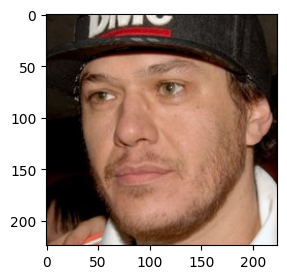

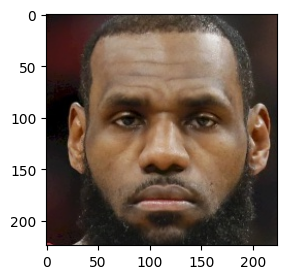

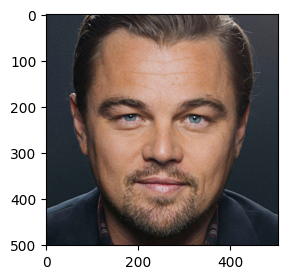

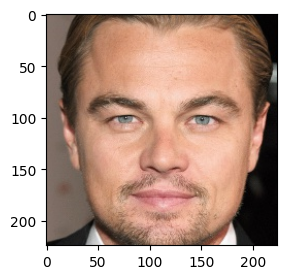

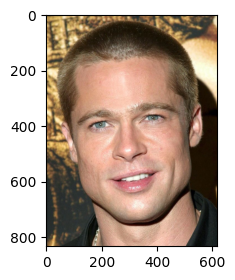

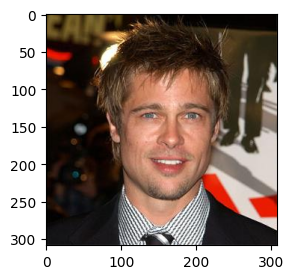

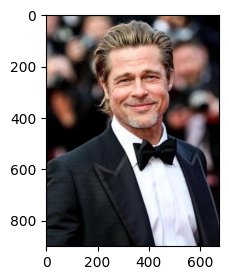

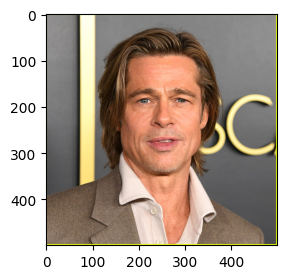

In [5]:
for path in image_path_list:
    plt.figure(figsize=(3,3))
    plt.imshow(X=np.asarray(a=load_image(path=path)))
    plt.show()

## [3.1] Inference

In [6]:
model = FaceRecognitionModel()

In [7]:
landmarks = [model(image=load_image(path=path)) for path in image_path_list]

I0000 00:00:1713965265.627146   34165 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713965265.689289   34227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2
W0000 00:00:1713965265.690048   34165 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1713965265.772873   34165 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713965265.862721   34240 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2
W0000 00:00:1713965265.863018   34165 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
I0000 00:00:1713965265.954718   34165 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713965266.049333   34253 gl_context.cc:3

## [3.2] Landmarks

In [8]:
def plot_3d_landmarks(landmarks: np.ndarray) -> None:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection="3d")

    ax.scatter(xs=landmarks[:,0], ys=landmarks[:,2], zs=landmarks[:,1], s=5, c="blue")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.set_xticks(ticks=np.arange(1, step=0.1))
    ax.set_yticks(ticks=np.arange(1, step=0.1))
    ax.set_zticks(ticks=np.arange(1, step=0.1))

    plt.show()
    plt.close(fig=fig)

def plot_landmarks(image: Image.Image, landmarks: np.ndarray) -> None:

    w, h = image.size
    
    plt.figure(figsize=(3,3))
    plt.imshow(X=np.asarray(a=image))
    plt.scatter(x=landmarks[:,0] * w, y=landmarks[:,1] * h, s=2, c="blue")
    plt.show()

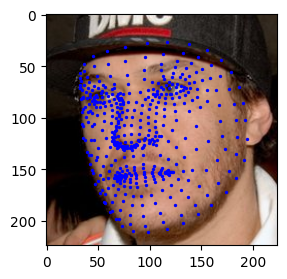

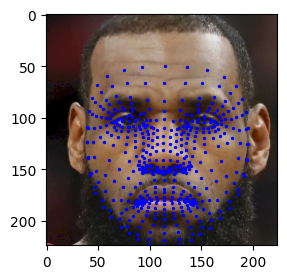

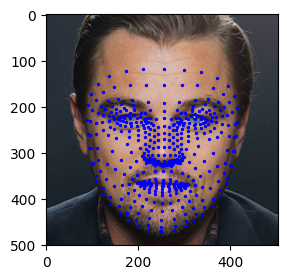

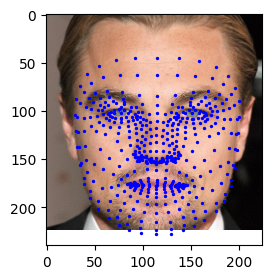

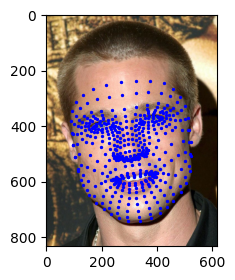

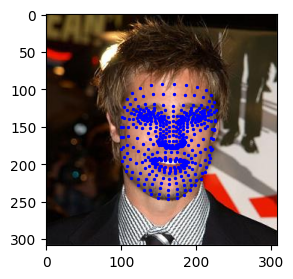

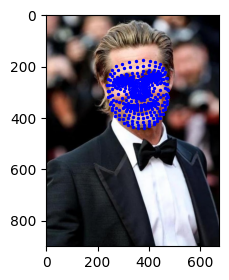

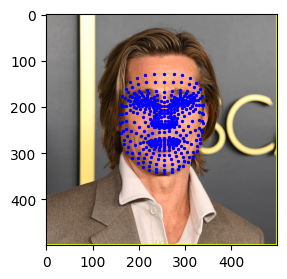

In [9]:
for path, landmark in zip(image_path_list, landmarks):
    plot_landmarks(image=load_image(path=path), landmarks=landmark)